In [10]:
import preprocess as pp
import configs
import persister
import relation
import lda

import re
import json

from stanfordcorenlp import StanfordCoreNLP
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.tree import Tree
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# 文档向量化测试
# count vectorizer

In [ ]:
a = "Many existing knowledge bases(KBs), including Freebase, Yago, and NELL, rely on a ﬁxed ontology, given as an input to the system, which deﬁnes the data to be cataloged in the KB, i.e., a hierarchy of categories and relations between them. The system then extracts facts that match the predeﬁned ontology. We propose an unsupervised model that jointly learns a latent ontological structure of an input corpus, and identiﬁes facts from the corpus that match the learned structure. Our approach combines mixed membership stochastic block models and topic models to infer a structure by jointly modeling text, a latent concept hierarchy, and latent semantic relationships among the entities mentioned in the text. As a case study, we apply the model to a corpus of Web documents from the software domain,and evaluate the accuracy of the various components of the learned ontology. "
b = ["hello world. what the fuck."]

In [ ]:
c = [" ".join(preprocess(a))]
vector = CountVectorizer(ngram_range=(1, 2), vocabulary=["knowledge base"], stop_words='english')
vector.build_analyzer()
x = vector.fit_transform(c)

In [ ]:
estimator = CountVectorizer(ngram_range=(1, 2), vocabulary=['fuck', 'hello', 'world', "hello world"], stop_words='english')
estimator.build_analyzer()
res = estimator.fit_transform(b)

In [ ]:
estimator.get_feature_names()

In [ ]:
res.toarray()
# estimator.vocabulary_

In [ ]:
# 斯坦福nlp工具测试
# stanfordcorenlp

In [ ]:
nlp = StanfordCoreNLP('/mnt/d/stanford-corenlp-full-2018-02-27', port=9000)
sentence = 'Brink is taking part in the final exercise.'
print('Tokenize:', nlp.word_tokenize(sentence))
print('Part of Speech:', nlp.pos_tag(sentence))
print('Named Entities:', nlp.ner(sentence))
print('Constituency Parsing:', nlp.parse(sentence))
print('Dependency Parsing:', nlp.dependency_parse(sentence))

nlp.close() # Do not forget to close! The backend server will consume a lot memery.

In [ ]:
# 官方corenlp api
# stanza

In [ ]:
from stanza.server import CoreNLPClient
with CoreNLPClient(properties="./corenlp_server.props", timeout=30000, memory='5G') as client:
    res = relation.corenlp_annotate(client, pp.format_news(newsdata[0]))

In [ ]:
# 新闻数据集测试
# 20newsgroups

In [ ]:
import newsgroups
size = 500
tmp = newsgroups.get_news_data(size)
newsdata = []
for cate in tmp:
    newsdata.extend(cate)

In [ ]:
texts = [' '.join(pp.preprocess_abstract(a))
persister.save_json(configs.NEWSDATA, texts)

In [ ]:
# 处理成句子
# nltk.sent_tokenize

In [ ]:
newssent = []
for news in newsdata:
    newssent.append(pp.split2sent(news))
persister.save_json(configs.NEWSSENT, newssent)

In [ ]:
newssenttoken = []
for news in newssent:
    tokenized_lemmatized_news = []
    for sent in news:
        tokenized_lemmatized_news.append(relation.lemmatize_sent_words(sent))
    newssenttoken.append(tokenized_lemmatized_news)
persister.save_json(configs.NEWSSENTTOKEN, newssenttoken)

In [ ]:
# load preprossed data

In [3]:
rawnews = persister.load_json(configs.RAWNEWS)
newsparse = persister.read_parse()

In [2]:
# load lda res
lda_input = persister.read_input(configs.NEWSINPUT)
terms, doc_topic, topic_word = persister.read_lda(configs.NEWSLDA)
lda.print_topics(topic_word, terms, doc_topic)
top_terms, top_docs = lda.get_topics(topic_word, terms, doc_topic)

# 1 --------------------
year:508.9541866901299
game:443.9033618736783
write:438.65308659853997
article:366.4270013554107
team:337.18548035608643
run:313.780031982071
win:307.57820232525216
think:297.71196933094467
good:270.6223635495843
player:260.09724357320573
hit:247.2249012648063
say:224.46544095582897
like:223.52287256311007
baseball:216.24809130707138
make:206.71042706363016
know:206.22949787872153
play:199.50017715000413
better:194.14766649928782
time:189.31177118340523
come:186.9605581601146
1857:0.9992238321423526
1757:0.9988149661211185
1533:0.9981753380975742
1538:0.9981230250615637
1552:0.9980779321475917
1750:0.9980614086589686
1925:0.9979448183244712
1628:0.9979084452266498
1555:0.9978550648191368
1569:0.9977813916090588
1664:0.9976221762961838
1521:0.9974370977104446
1656:0.9974313539615932
1923:0.9974045980841548
1577:0.9973554221245231
1927:0.9971204221797614
1512:0.9968003777481905
1893:0.9967765449682371
1568:0.9966854206514347
1966:0.9965845954336768
# 2 ----------

In [7]:
param = lda.generate_lda_parameter(2,8,2,100)
tf, _ = lda.extract_feature(lda_input)
model = lda.gridsearchCV(param, tf)

func extract_feature exec time: 0.3328721523284912
func gridsearchCV exec time: 2116.7770416736603


In [11]:
print(model.best_estimator_.perplexity(tf))
pd.DataFrame(model.cv_results_)

3982.2215386460666


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_learning_decay,param_learning_method,param_max_iter,param_n_components,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,163.988342,9.160809,0.458747,0.052197,128,0.5,online,100,2,0,"{'batch_size': 128, 'learning_decay': 0.5, 'le...",-380353.370148,-467148.648611,-455539.059726,-300155.684572,-277812.060993,-376201.764810,77519.698143,1
1,165.557594,2.746555,0.574846,0.067207,128,0.5,online,100,4,0,"{'batch_size': 128, 'learning_decay': 0.5, 'le...",-401853.210712,-484655.038732,-469482.694829,-316743.267635,-293399.008725,-393226.644126,77542.011748,6
2,157.567629,6.848961,0.440561,0.050502,128,0.5,online,100,6,0,"{'batch_size': 128, 'learning_decay': 0.5, 'le...",-414787.378287,-494621.760652,-481910.165183,-329635.281048,-306540.801663,-405499.077367,76701.806333,9
3,153.572843,3.999041,0.469639,0.057217,128,0.7,online,100,2,0,"{'batch_size': 128, 'learning_decay': 0.7, 'le...",-380563.282433,-467467.276657,-455533.746300,-300372.372228,-278553.557851,-376498.047094,77365.121291,2
4,162.620523,14.947876,0.587544,0.077781,128,0.7,online,100,4,0,"{'batch_size': 128, 'learning_decay': 0.7, 'le...",-401116.363384,-488166.744452,-468828.690617,-314036.364971,-292825.492494,-392994.731184,78921.178903,5
5,202.986743,6.626741,0.698683,0.166312,128,0.7,online,100,6,0,"{'batch_size': 128, 'learning_decay': 0.7, 'le...",-414231.835907,-491898.100066,-479187.411902,-323782.149397,-303507.558179,-402521.411090,77468.208528,8
6,186.126028,5.951373,0.493955,0.107911,128,0.9,online,100,2,0,"{'batch_size': 128, 'learning_decay': 0.9, 'le...",-380670.757490,-467356.457289,-455399.729700,-301781.553797,-280161.889926,-377074.077641,76628.569380,3
7,152.445740,5.213483,0.510927,0.060969,128,0.9,online,100,4,0,"{'batch_size': 128, 'learning_decay': 0.9, 'le...",-392174.721214,-485185.334291,-469256.075397,-309685.991277,-290321.488165,-389324.722069,79662.247622,4
8,155.853137,4.780468,0.508489,0.091187,128,0.9,online,100,6,0,"{'batch_size': 128, 'learning_decay': 0.9, 'le...",-405520.012345,-495813.363481,-479878.148003,-323896.744726,-299043.224357,-400830.298582,79462.845052,7


[-376202.0, -393227.0, -405499.0]
[-376498.0, -392995.0, -402521.0]


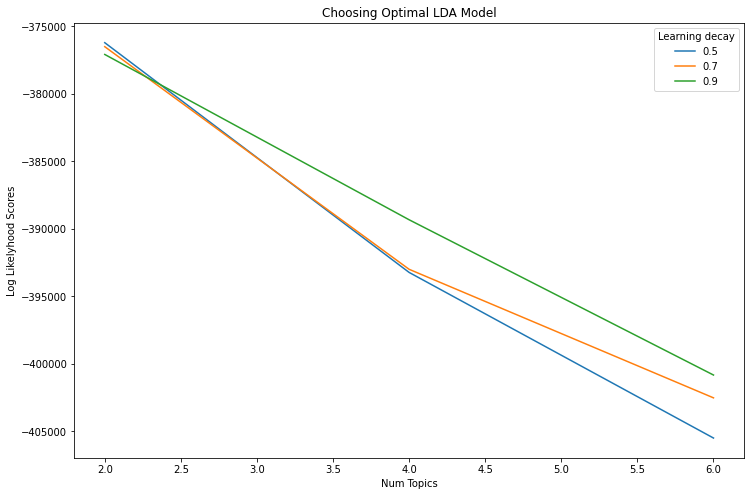

In [9]:
n_topics = list(range(2,8,2))
score = 'mean_test_score'
# score = 'std_test_score'
log_likelyhoods_5 = [round(s) for s in model.cv_results_[score][:len(n_topics)]] 
log_likelyhoods_7 = [round(s) for s in model.cv_results_[score][len(n_topics):2*len(n_topics)]]
log_likelyhoods_9 = [round(s) for s in model.cv_results_[score][2*len(n_topics):3*len(n_topics)]]

# Show graph
plt.figure(figsize=(12, 8))
print(log_likelyhoods_5)
print(log_likelyhoods_7)
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [3]:
terms, doc_topic, topic_word, perplexity, score, bound, itercount,i = lda.new_lda(lda_input, topic_num=4)
print(perplexity,score,bound,itercount,i)

3593.5234556659657 -1620275.2828254758 3593.5234556659657 21 20


In [ ]:
from functools import reduce
failed_idxs = []
for idx, i in enumerate(newsparse):
    if type(i) == str:
        failed_idxs.append(idx)
print(len(set(failed_idxs) & set(map(lambda x:x[0], reduce(lambda x,y:x+y, top_docs)))))
print(len(set(map(lambda x:x[0], reduce(lambda x,y:x+y, top_docs)))))

In [ ]:
idx_news = 1195
idx_sent = 40

In [ ]:
print(pos_tag(word_tokenize(newssent[idx_news][43])))
print(pp.WNL.lemmatize("has", wordnet.VERB))

In [ ]:
print(len(newsparse[idx_news]["sentences"]))
print(newsparse[idx_news]["sentences"][idx_sent].keys())
examparse = newsparse[idx_news]["sentences"][idx_sent]
print(examparse["enhancedPlusPlusDependencies"])

In [ ]:
tt = Tree.fromstring(examparse["parse"])
tt.pretty_print()

In [ ]:
t4 = [t[0] for t in top_terms[3]]
t4_values = [t[1] for t in top_terms[3]]
print(t4)
print(t4_values)
idxs, importance, count = relation.extract_important_sents(newssenttoken[idx_news], t4, t4_values)
print(idxs, importance[40], count[40])

In [ ]:
relation.extract_word_relation_from_sent(i, newsparse[1200]["sentences"][sent_idx]["enhancedDependencies"])

In [ ]:
for term in top_terms[3]:
    for news in top_docs[3]:
        time.sleep(2)
        news_idx = news[0]
        for sent_idx,sent in enumerate(newssenttoken[news_idx]):
            if type(newsparse[news_idx]) is str:
                print(news_idx, "parse", "err")
                break
            topic_word_idxs = relation.get_word_idx(term[0], sent)
            for i in topic_word_idxs:
                print(sent_idx, i, news_idx)
                rs = relation.extract_word_relation_from_sent(i, newsparse[news_idx]["sentences"][sent_idx]["enhancedDependencies"])
                for r in rs:
                    print(relation.convert_relation2str(r))

In [ ]:
t = Tree.fromstring(newsparse[idx_news]["sentences"][5]["parse"])
t.pretty_print()

In [ ]:
# abstract data

In [12]:
raw_data = persister.load_json(configs.RAWABSTRACT)
abslda_input = persister.read_input(configs.ABSTRACTINPUT)
terms, doc_topic, topic_word = persister.read_lda(configs.ABSTRACTLDA)
absparse = persister.read_parse(configs.ABSTRACTPARSE)

In [ ]:
param = lda.generate_lda_parameter(5,30,5,10)
vec, _ = lda.extract_feature(abslda_input)
model = lda.gridsearchCV(param, vec)

func extract_feature exec time: 0.44123172760009766


In [ ]:
lda.print_topics(topic_word, terms, doc_topic)
top_terms, top_docs = lda.get_topics(topic_word, terms, doc_topic)